In [1]:
#(unfortunately confusing name): 
#notebook to make error matrix plots similar to Intermediate_Error_Plots_v2, 
#this time comparing V1 and V2 of E3 for the sensitivity tests that were run for both model versions.
#Based on intermediate_error_plots_v2 for the error calculations, 
#and Sensitivity_Test_Plots for the original plot of this type. 

#Started 24 February 2021

In [2]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.io #For loading .mat file
from scipy.stats import iqr

In [3]:
#Load mat files for individual tests

In [4]:
#Names of tests and variables
tnames = ['20YearTest',
'Ec050',
'Ec080',
'En030',
'En090']

#Order the variables by what they were like in Jeff's matrix plot
vnames = [
    'GPCP_precip', 
    'CMAP_STD_precip',
    'CMAP_EHD_precip',  
    'ISCCP_cldOptDep', 
    'ERA_I_slp', 
    'ICOADS_slp', 
    'CRUTEM_STD_tsurf', 
    'CRUTEM_EHD_tsurf', 
    'CERES_lwTOA', 
    'CERES_swTOA', 
    'ERA_I_850u', 
    'ERA_I_850v', 
    'ERA_I_200u', 
    'ERA_I_200v', 
    'ERA_I_500z', 
    'ERA_I_zonT', 
    'ICOADS_uStress', 
    'ICOADS_vStress', 
    'ERA_I_zonU', 
    'ERA_I_zonV', 
    'ISCCP_OAFLUX_qnet', 
    'CERES_OAFLUX_qnet',
    'ERA_I_zonQ', 
    'NSIDC_snow',
    'IBTRACS_trackDen', 
    'IBTRACS_genDen'
]

In [5]:
#Dict of variable names in the models matching those for the observations
E3_vnames = {
    'GPCP_precip': 'PREC', 
    'CMAP_STD_precip': 'PREC',
    'CMAP_EHD_precip': 'PREC',
    'ISCCP_cldOptDep': 'OPTD', 
    'ERA_I_slp': 'SLP',
    'ICOADS_slp': 'SLP',
    'CRUTEM_STD_tsurf': 'TSURF',
    'CRUTEM_EHD_tsurf': 'TSURF',
    'CERES_lwTOA': 'OLR',
    'CERES_swTOA': 'OSR',
    'ERA_I_850u': 'U850',
    'ERA_I_850v': 'V850', 
    'ERA_I_200u': 'U200', 
    'ERA_I_200v': 'V200', 
    'ERA_I_500z': 'Z500', 
    'ERA_I_zonT': 'Tzon', 
    'ICOADS_uStress': 'TAU', #Why are these the same? Or does Tau have 2 components?
    'ICOADS_vStress': 'TAU',
    'ERA_I_zonU': 'Uzon', 
    'ERA_I_zonV': 'Vzon', 
    'ISCCP_OAFLUX_qnet': 'QNET', 
    'CERES_OAFLUX_qnet': 'QNET', 
    'ERA_I_zonQ': 'Qzon', 
    'NSIDC_snow': 'SNOW', 
    'IBTRACS_trackDen': 'TRACK',
    'IBTRACS_genDen': 'GEN'
}

In [6]:
# Function to load an individual mat file into a dict
# Note this is a "kludge" solution for the one missing test that should be all zeros, 
# and shouldn't be generalized. 
# (The test printed 0 so it should still work)
# vname: name of variable
def load_intermediate_mat(tname, vname, version=1):
    version_string = {1: 'JS_C180_ObsRMSEs_', 
                      2: 'JS_C180v2_ObsRMSEs_'} #(glad I already put this in last time!)
    if vname == 'IBTRACS_genDen':
        if tname == 'En010':
            #No "corrected" file, load the uncorrected one (which should still be all zeros since track density should be 0 too)
            #(Unless a storm crossed over from one year to the next)
            mat_dict = scipy.io.loadmat('mat_intermediate/'+version_string[version]+tname+'_'+vname+'.mat')
            print('Loaded uncorrected genesis density for case with 0 TCs. Should still still be 0 because')
            print('this was the track density times 4, and if no TC genesis should be no tracks either. Max of the variable is:')
            print(np.max(mat_dict[E3_vnames[vname]])) #Make sure it is actually still 0 based on track
        elif version == 2:
            mat_dict = scipy.io.loadmat('mat_intermediate/'+version_string[version]+tname+'_'+vname+'.mat')
        else:
            mat_dict = scipy.io.loadmat('mat_intermediate/'+version_string[version]+tname+'_'+vname+'_corrected.mat')
    else:
        mat_dict = scipy.io.loadmat('mat_intermediate/'+version_string[version]+tname+'_'+vname+'.mat')
    return mat_dict

In [7]:
# Wrapper function to construct an XArray dataset from the above
def load_mat_to_dataset(tname, vname, version=1):
    mat_dict = load_intermediate_mat(tname, vname, version=version)
    if vname in ['ERA_I_zonQ', 'ERA_I_zonT', 'ERA_I_zonU', 'ERA_I_zonV']: #LAT_O, LEV_O dimensions
        lat = mat_dict['LAT_O'][:,0]
        lev = mat_dict['LEV_O'][0,:]
        #print(lat)
        #print(lev)
        model_array = xr.DataArray(mat_dict[E3_vnames[vname]], 
                                   coords={'lat': lat, 
                                           'lev': lev},  
                                   dims=['lat', 'lev'], 
                                   name=E3_vnames[vname])
        obs_array = xr.DataArray(mat_dict[vname], 
                                 coords={'lat': lat, 
                                         'lev': lev},  
                                 dims=['lat', 'lev'], 
                                 name=vname)
    elif vname in ['IBTRACS_trackDen', 'IBTRACS_genDen']: #Put in lat, lon manually. 
        #Should've saved "IBTRACS_lon", "IBTRACS_lat" variables. But, they were rearranged to be
        #ocean-centric: 335W-25E
        #How does this fit into -180 to 180 or 0 to 360 longitudes?
        lat = np.linspace(-89.5, 89.5, 180)
        lon = np.linspace(-334.5, 24.5, 360)
        model_array = xr.DataArray(mat_dict[E3_vnames[vname]], 
                                   coords={'lon': lon, 
                                           'lat': lat},  
                                   dims=['lon', 'lat'], 
                                   name=E3_vnames[vname])
        obs_array = xr.DataArray(mat_dict[vname], 
                                 coords={'lon': lon, 
                                         'lat': lat},  
                                 dims=['lon', 'lat'], 
                                 name=vname)
    elif vname == 'NSIDC_snow': #Downsample lat/lon to every 10th
        lat = mat_dict['LAT_O'][0,4:3600:10]+0.025
        lon = mat_dict['LON_O'][4:7200:10,0]+0.025
        print('about to make snow arrays')
        model_array = xr.DataArray(mat_dict[E3_vnames[vname]], 
                                   coords={'lon': lon, 
                                           'lat': lat},  
                                   dims=['lon', 'lat'], 
                                   name=E3_vnames[vname])
        obs_array = xr.DataArray(mat_dict[vname], 
                                 coords={'lon': lon, 
                                         'lat': lat},  
                                 dims=['lon', 'lat'], 
                                 name=vname)
        print('made snow arrays')
    else: #LAT_O, LON_O dimensions
        lat = mat_dict['LAT_O'][0,:]
        lon = mat_dict['LON_O'][:,0]
        #print(lat)
        #print(lon)
        model_array = xr.DataArray(mat_dict[E3_vnames[vname]], 
                                   coords={'lon': lon, 
                                           'lat': lat},  
                                   dims=['lon', 'lat'], 
                                   name=E3_vnames[vname])
        obs_array = xr.DataArray(mat_dict[vname], 
                                 coords={'lon': lon, 
                                         'lat': lat},  
                                 dims=['lon', 'lat'], 
                                 name=vname)
    ds_merged = xr.merge([model_array, obs_array])
    return ds_merged

In [8]:
#2nd wrapper function to run the above for all of the tests, and concatenate into an XArray dataset along the test dimension
def mat_to_dataset_all_tests(tnames, vname, version=1):
    ds_dict = dict()
    for tname in tnames:
        #print('Loading mat files for test: ' + tname)
        ds_dict[tname] = load_mat_to_dataset(tname, vname, version=version)
    ds_concat = xr.concat(ds_dict.values(), dim=pd.Index(tnames, name='tname'))
    return ds_concat

In [9]:
#Test with genesis density, separately for V1 and V2
test_td_1 = mat_to_dataset_all_tests(tnames, 'IBTRACS_genDen', version=1)
test_td_2 = mat_to_dataset_all_tests(tnames, 'IBTRACS_genDen', version=2)

In [10]:
#Run for all cases now: load into separate dicts for V1 and V2
mat_ds_dict_v1 = dict()
for vname in vnames:
    print('Loading mat files (v1) for variable: ' + vname)
    mat_ds_dict_v1[vname] = mat_to_dataset_all_tests(tnames, vname, version=1)

Loading mat files (v1) for variable: GPCP_precip
Loading mat files (v1) for variable: CMAP_STD_precip
Loading mat files (v1) for variable: CMAP_EHD_precip
Loading mat files (v1) for variable: ISCCP_cldOptDep
Loading mat files (v1) for variable: ERA_I_slp
Loading mat files (v1) for variable: ICOADS_slp
Loading mat files (v1) for variable: CRUTEM_STD_tsurf
Loading mat files (v1) for variable: CRUTEM_EHD_tsurf
Loading mat files (v1) for variable: CERES_lwTOA
Loading mat files (v1) for variable: CERES_swTOA
Loading mat files (v1) for variable: ERA_I_850u
Loading mat files (v1) for variable: ERA_I_850v
Loading mat files (v1) for variable: ERA_I_200u
Loading mat files (v1) for variable: ERA_I_200v
Loading mat files (v1) for variable: ERA_I_500z
Loading mat files (v1) for variable: ERA_I_zonT
Loading mat files (v1) for variable: ICOADS_uStress
Loading mat files (v1) for variable: ICOADS_vStress
Loading mat files (v1) for variable: ERA_I_zonU
Loading mat files (v1) for variable: ERA_I_zonV
Loa

In [11]:
#Run for all cases now: load into separate dicts for V1 and V2
mat_ds_dict_v2 = dict()
for vname in vnames:
    print('Loading mat files (v2) for variable: ' + vname)
    mat_ds_dict_v2[vname] = mat_to_dataset_all_tests(tnames, vname, version=2)

Loading mat files (v2) for variable: GPCP_precip
Loading mat files (v2) for variable: CMAP_STD_precip
Loading mat files (v2) for variable: CMAP_EHD_precip
Loading mat files (v2) for variable: ISCCP_cldOptDep
Loading mat files (v2) for variable: ERA_I_slp
Loading mat files (v2) for variable: ICOADS_slp
Loading mat files (v2) for variable: CRUTEM_STD_tsurf
Loading mat files (v2) for variable: CRUTEM_EHD_tsurf
Loading mat files (v2) for variable: CERES_lwTOA
Loading mat files (v2) for variable: CERES_swTOA
Loading mat files (v2) for variable: ERA_I_850u
Loading mat files (v2) for variable: ERA_I_850v
Loading mat files (v2) for variable: ERA_I_200u
Loading mat files (v2) for variable: ERA_I_200v
Loading mat files (v2) for variable: ERA_I_500z
Loading mat files (v2) for variable: ERA_I_zonT
Loading mat files (v2) for variable: ICOADS_uStress
Loading mat files (v2) for variable: ICOADS_vStress
Loading mat files (v2) for variable: ERA_I_zonU
Loading mat files (v2) for variable: ERA_I_zonV
Loa

In [12]:

#####   Calculate Error Diagnostics   #####


In [13]:
#Similar to what I ultimately used  V1, taking means on both dimensions at once.
#Define a function and run for V1 and V2. 

In [14]:
def calc_error_metrics(mat_ds_dict):
    for vname in mat_ds_dict.keys():
        print('Calculating error diagnostics for: ' + vname)
    
        #Calculate RMSE -- non latitude weighted
        mod_data = mat_ds_dict[vname][E3_vnames[vname]]
        obs_data = mat_ds_dict[vname][vname]
        raw_error = mod_data - obs_data
        #Take mean across the lon (or lev) and lat dimensions but not tname dimension 
        if vname in ['ERA_I_zonQ', 'ERA_I_zonT', 'ERA_I_zonU', 'ERA_I_zonV']:
            mean_squared_error = (raw_error*raw_error).mean(dim=['lev', 'lat'])
        else:
            mean_squared_error = (raw_error*raw_error).mean(dim=['lon', 'lat'])
        RMSE_unweighted = np.sqrt(mean_squared_error)
        mat_ds_dict[vname]['RMSE_unweighted'] = RMSE_unweighted
        
        #Calculate RMSE -- latitude weighted
        lat_weights = np.cos(mat_ds_dict[vname]['lat']*np.pi/180.)
        ones_grid = mat_ds_dict[vname][vname].isel(tname=0).fillna(0)*0+1.0 #Create grid of ones that's an xarray
        weight_grid = ones_grid*lat_weights
        weight_grid_masked = weight_grid*np.logical_not(np.isnan(raw_error))
        #print(weight_grid_masked)
        squared_error_times_weights = raw_error*raw_error*weight_grid_masked
        dot_product = (raw_error*raw_error).dot(lat_weights) 
        if vname in ['ERA_I_zonQ', 'ERA_I_zonT', 'ERA_I_zonU', 'ERA_I_zonV']:
            sum_squared_error_weighted = squared_error_times_weights.sum(dim=['lev', 'lat'])
            sum_weights_masked = weight_grid_masked.sum(dim=['lev', 'lat'])
        else:
            sum_squared_error_weighted = squared_error_times_weights.sum(dim=['lon', 'lat'])
            sum_weights_masked = weight_grid_masked.sum(dim=['lon', 'lat'])
        RMSE_weighted = np.sqrt(sum_squared_error_weighted/sum_weights_masked)
        mat_ds_dict[vname]['RMSE_weighted'] = RMSE_weighted
        
        #Calculate global means of the modeled and observed quantity and their difference
        if vname in ['ERA_I_zonQ', 'ERA_I_zonT', 'ERA_I_zonU', 'ERA_I_zonV']:
            gm_mod = (mod_data*weight_grid_masked).sum(dim=['lev', 'lat'])/sum_weights_masked
            gm_obs = (obs_data*weight_grid_masked).sum(dim=['lev', 'lat'])/sum_weights_masked
        else:
            gm_mod = (mod_data*weight_grid_masked).sum(dim=['lon', 'lat'])/sum_weights_masked
            gm_obs = (obs_data*weight_grid_masked).sum(dim=['lon', 'lat'])/sum_weights_masked
        diff_global_means = gm_mod - gm_obs
        mat_ds_dict[vname]['gm_mod'] = gm_mod
        mat_ds_dict[vname]['gm_obs'] = gm_obs
        mat_ds_dict[vname]['diff_global_means'] = diff_global_means
        
    return

In [15]:
calc_error_metrics(mat_ds_dict_v1)

Calculating error diagnostics for: GPCP_precip
Calculating error diagnostics for: CMAP_STD_precip
Calculating error diagnostics for: CMAP_EHD_precip
Calculating error diagnostics for: ISCCP_cldOptDep
Calculating error diagnostics for: ERA_I_slp
Calculating error diagnostics for: ICOADS_slp
Calculating error diagnostics for: CRUTEM_STD_tsurf
Calculating error diagnostics for: CRUTEM_EHD_tsurf
Calculating error diagnostics for: CERES_lwTOA
Calculating error diagnostics for: CERES_swTOA
Calculating error diagnostics for: ERA_I_850u
Calculating error diagnostics for: ERA_I_850v
Calculating error diagnostics for: ERA_I_200u
Calculating error diagnostics for: ERA_I_200v
Calculating error diagnostics for: ERA_I_500z
Calculating error diagnostics for: ERA_I_zonT
Calculating error diagnostics for: ICOADS_uStress
Calculating error diagnostics for: ICOADS_vStress
Calculating error diagnostics for: ERA_I_zonU
Calculating error diagnostics for: ERA_I_zonV
Calculating error diagnostics for: ISCCP_OA

In [16]:
calc_error_metrics(mat_ds_dict_v2)

Calculating error diagnostics for: GPCP_precip
Calculating error diagnostics for: CMAP_STD_precip
Calculating error diagnostics for: CMAP_EHD_precip
Calculating error diagnostics for: ISCCP_cldOptDep
Calculating error diagnostics for: ERA_I_slp
Calculating error diagnostics for: ICOADS_slp
Calculating error diagnostics for: CRUTEM_STD_tsurf
Calculating error diagnostics for: CRUTEM_EHD_tsurf
Calculating error diagnostics for: CERES_lwTOA
Calculating error diagnostics for: CERES_swTOA
Calculating error diagnostics for: ERA_I_850u
Calculating error diagnostics for: ERA_I_850v
Calculating error diagnostics for: ERA_I_200u
Calculating error diagnostics for: ERA_I_200v
Calculating error diagnostics for: ERA_I_500z
Calculating error diagnostics for: ERA_I_zonT
Calculating error diagnostics for: ICOADS_uStress
Calculating error diagnostics for: ICOADS_vStress
Calculating error diagnostics for: ERA_I_zonU
Calculating error diagnostics for: ERA_I_zonV
Calculating error diagnostics for: ISCCP_OA

In [17]:
# print(mat_ds_dict_v1)
# print(mat_ds_dict_v2)

#Yes, the new variable names were added.

In [18]:

#####   Combine into 26x10 matrices    #####


In [19]:
mat_RMSE_u = np.zeros([len(vnames), 10])
mat_RMSE_w = np.zeros([len(vnames), 10])
mat_RMSE_gm_mod = np.zeros([len(vnames), 10])
mat_RMSE_gm_obs = np.zeros([len(vnames), 10])
mat_RMSE_dgm = np.zeros([len(vnames), 10])
i = 0
for vname in vnames:
    mat_RMSE_u[i,0:5] = mat_ds_dict_v1[vname]['RMSE_unweighted']
    mat_RMSE_w[i,0:5] = mat_ds_dict_v1[vname]['RMSE_weighted']
    mat_RMSE_gm_mod[i,0:5] = mat_ds_dict_v1[vname]['gm_mod']
    mat_RMSE_gm_mod[i,0:5] = mat_ds_dict_v1[vname]['gm_mod']
    mat_RMSE_dgm[i,0:5] = mat_ds_dict_v1[vname]['diff_global_means']
    mat_RMSE_u[i,5:10] = mat_ds_dict_v2[vname]['RMSE_unweighted']
    mat_RMSE_w[i,5:10] = mat_ds_dict_v2[vname]['RMSE_weighted']
    mat_RMSE_gm_mod[i,5:10] = mat_ds_dict_v2[vname]['gm_mod']
    mat_RMSE_gm_mod[i,5:10] = mat_ds_dict_v2[vname]['gm_mod']
    mat_RMSE_dgm[i,5:10] = mat_ds_dict_v2[vname]['diff_global_means']
    i = i + 1

In [20]:

#####   Calculate normalizations across the 10 experiments   #####


In [21]:
#Normalize by IQR and subtract median (for unweighted, weighted RMSEs)
def norm_IQR_median(mat_2D):
    row_IQR = iqr(mat_2D, axis=1)
    div_IQR = mat_2D/row_IQR[:,None]
    med_divIQR = np.median(div_IQR, axis=1)
    norm_mat = div_IQR - med_divIQR[:,None]
    return norm_mat

In [22]:
norm_RMSE_u = norm_IQR_median(mat_RMSE_u)
norm_RMSE_w = norm_IQR_median(mat_RMSE_w)

In [23]:
#Normalize by dividing by median of the absolute values of the anomalies (for global mean diff.)
def norm_med_abs(mat_2D):
    row_med_abs = np.median(np.abs(mat_2D), axis=1)
    return mat_2D / row_med_abs[:,None]

In [24]:
norm_dgm = norm_med_abs(mat_RMSE_dgm)

In [25]:

#####   PLOTS   #####


In [26]:
#Shortened plot label strings

fnums = ['Default',
'50',
'200',
'.05',
'.07',
'.09',
'.04',
'.06',
'.08',
'.06',
'.07',
'.08',
'.09',
'.10',
'.11',
'.12',
'.13',
'.14',
'.15',
'.16',
'.17',
'.18',
'.19',
'.40',
'.50',
'.60',
'.70',
'.80',
'.10',
'.20',
'.30',
'.40',
'.50',
'.70',
'.80',
'.85',
'.90',
'.95',
'.97',
'.99',
'.05',
'.07',
'.09',
'.04',
'.06',
'.08',
'.09',
'.13',
'.17',
'.40',
'.60',
'.80']

onames = ['Pr. (GP)', 
          'Pr. (C1)', 
          'Pr. (C2)', 
          '$\\tau_{\mathrm{cld}}$', 
          'SLP (1)', 
          'SLP (2)', 
          '$T_s$ (1)', 
          '$T_s$ (2)', 
          'OLR', 
          'OSR', 
          '$u_{850}$',
          '$v_{850}$', 
          '$u_{200}$', 
          '$v_{200}$', 
          '$z_{g,500}$', 
          '[$T_a$]', 
          '$\\tau_{u,\mathrm{sfc.}}$',
          '$\\tau_{v,\mathrm{sfc.}}$',
          '[$u$]',
          '[$v$]', 
          '$Q_\mathrm{net,surf.}$ (1)', 
          '$Q_\mathrm{net,surf.}$ (2)', 
          '[$q$]', 
          'Snow Frac.', 
          'Track Dens.', 
          'Gen. Dens.']

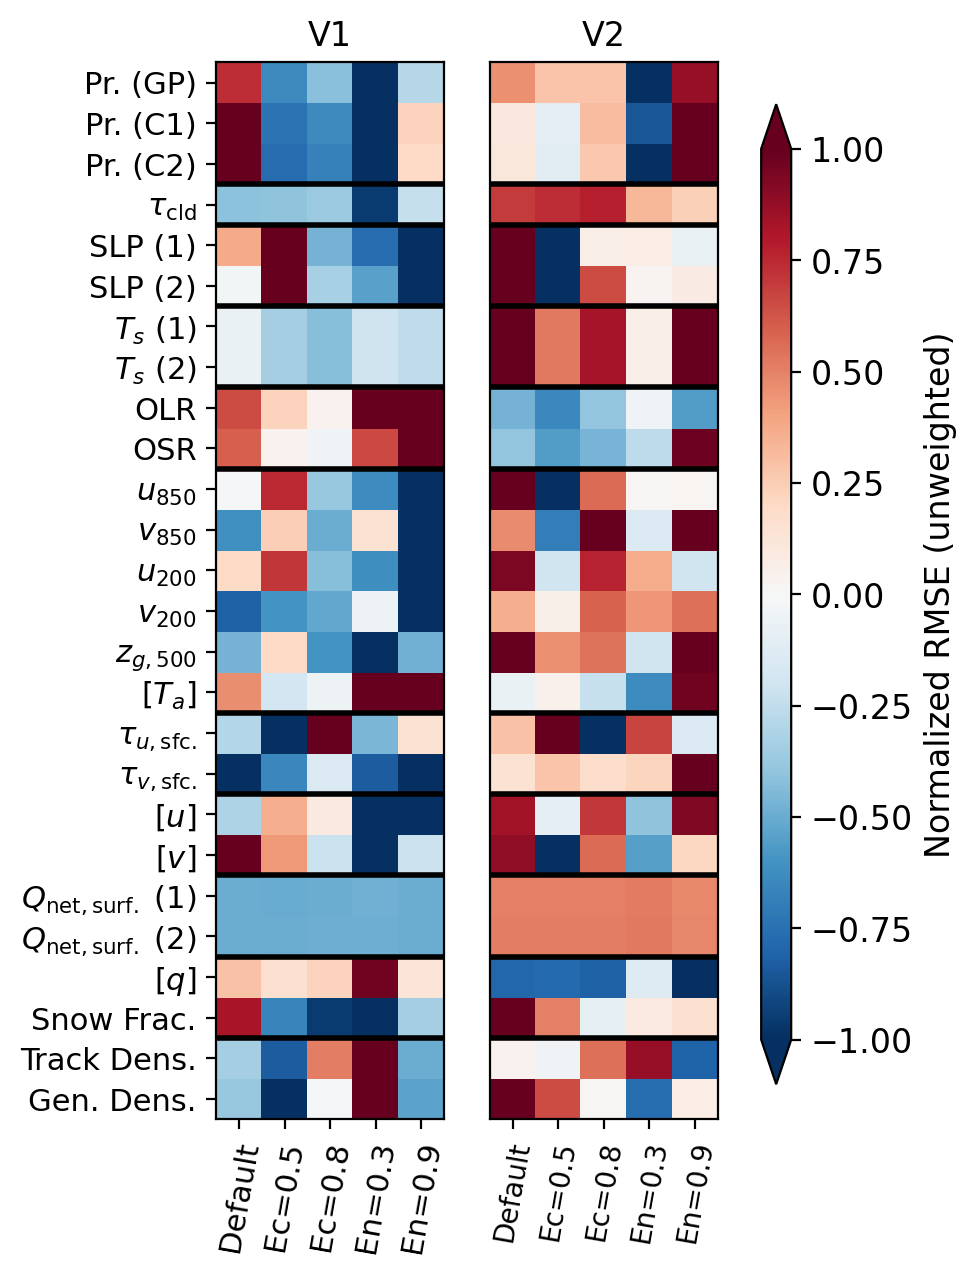

In [36]:
#Unweighted plot

#Make plot, 2 panels (one for V1, one for V2)
fig = plt.figure(figsize=(5,7), dpi=200)

plotmat = np.flipud(norm_RMSE_u)

plt.subplot(1,3,1)
plt.pcolor(plotmat[:,0:5], cmap = plt.cm.RdBu_r, 
           vmin=-1, vmax=1)
plt.title('V1', fontsize=12)
ax = plt.gca()
ax.tick_params(labelsize=11)
ax.set_yticks(np.arange(26)+0.5)
ax.set_yticklabels(np.flip(onames))
ax.set_xticks(np.arange(5)+0.5)
ax.set_xticklabels(['Default', 'Ec=0.5', 'Ec=0.8', 'En=0.3', 'En=0.9'])
plt.xticks(rotation=80)
plt.hlines([2, 4, 6, 8, 10, 16, 18, 20, 22, 23], 
           0, 5, linestyles='solid', linewidth=2, colors='k')

plt.subplot(1,3,2)
plt.pcolor(plotmat[:,5:10], cmap = plt.cm.RdBu_r, 
           vmin=-1, vmax=1)
plt.title('V2', fontsize=12)
ax = plt.gca()
ax.set_yticks([])
ax.set_xticks(np.arange(5)+0.5)
ax.set_xticklabels(['Default', 'Ec=0.5', 'Ec=0.8', 'En=0.3', 'En=0.9'])
plt.xticks(rotation=80)
plt.hlines([2, 4, 6, 8, 10, 16, 18, 20, 22, 23], 
           0, 5, linestyles='solid', linewidth=2, colors='k')

cbar = plt.colorbar(cax=fig.add_axes([0.67, 0.15, 0.03, 0.7]), extend='both')
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_ylabel('Normalized RMSE (unweighted)', fontsize=12)


plt.savefig('plots/V1V2_RMSE_unweighted.png', bbox_inches='tight')
plt.savefig('plots/V1V2_RMSE_unweighted.pdf', bbox_inches='tight')


In [37]:
#OK, this looks all right. Similar to what I had in Sensitivity_Test_Plots (except was originally upside down!)
#Genesis density has been fixed; expect slight differences in some other variables due to 
#averaging dimension order.

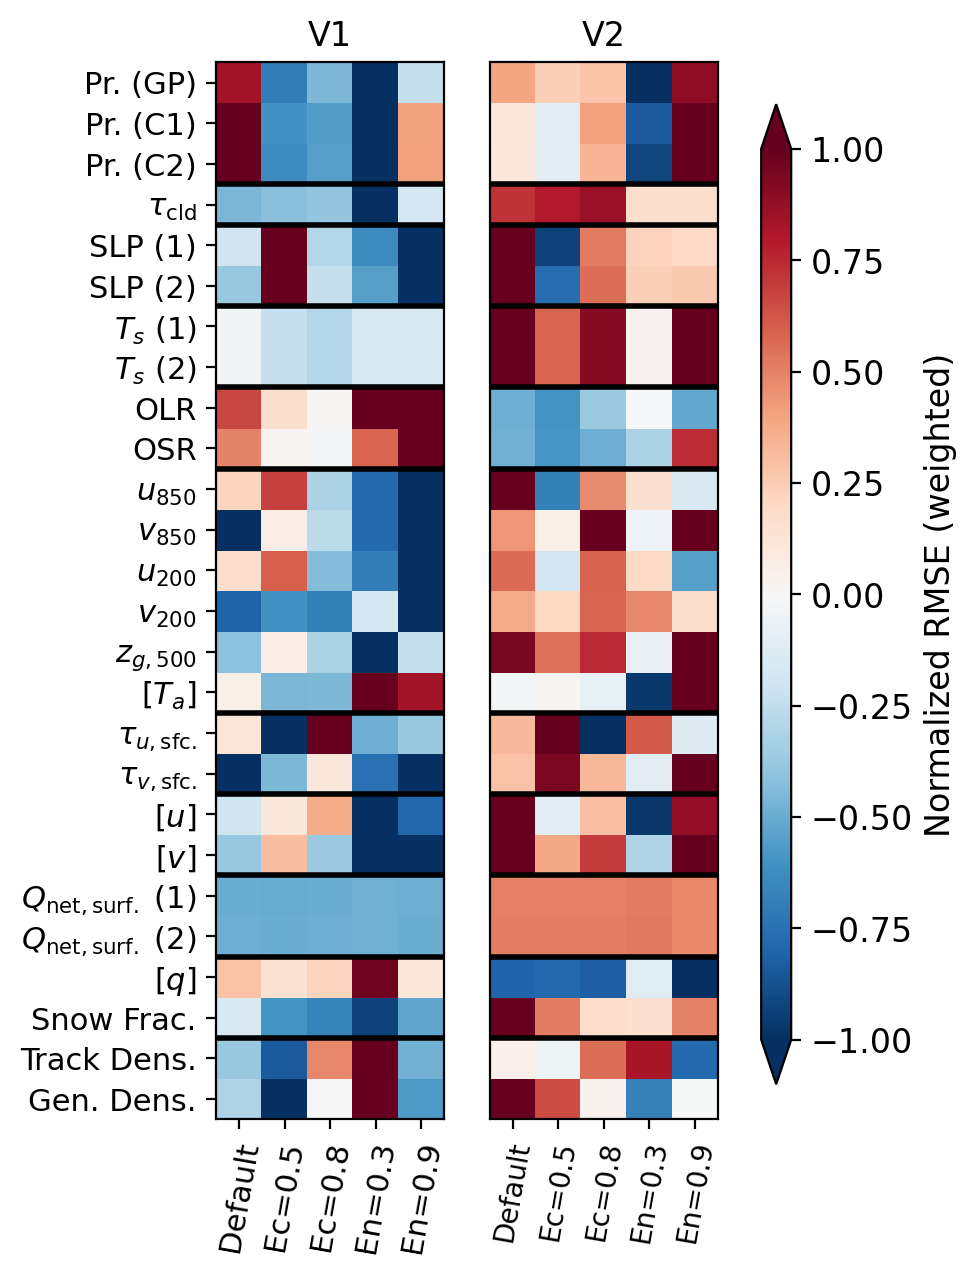

In [27]:
#Area-weighted version

fig = plt.figure(figsize=(5,7), dpi=200)

plotmat = np.flipud(norm_RMSE_w)

plt.subplot(1,3,1)
plt.pcolor(plotmat[:,0:5], cmap = plt.cm.RdBu_r, 
           vmin=-1, vmax=1)
plt.title('V1', fontsize=12)
ax = plt.gca()
ax.tick_params(labelsize=11)
ax.set_yticks(np.arange(26)+0.5)
ax.set_yticklabels(np.flip(onames))
ax.set_xticks(np.arange(5)+0.5)
ax.set_xticklabels(['Default', 'Ec=0.5', 'Ec=0.8', 'En=0.3', 'En=0.9'])
plt.xticks(rotation=80)
plt.hlines([2, 4, 6, 8, 10, 16, 18, 20, 22, 23], 
           0, 5, linestyles='solid', linewidth=2, colors='k')

plt.subplot(1,3,2)
plt.pcolor(plotmat[:,5:10], cmap = plt.cm.RdBu_r, 
           vmin=-1, vmax=1)
plt.title('V2', fontsize=12)
ax = plt.gca()
ax.set_yticks([])
ax.set_xticks(np.arange(5)+0.5)
ax.set_xticklabels(['Default', 'Ec=0.5', 'Ec=0.8', 'En=0.3', 'En=0.9'])
plt.xticks(rotation=80)
plt.hlines([2, 4, 6, 8, 10, 16, 18, 20, 22, 23], 
           0, 5, linestyles='solid', linewidth=2, colors='k')

cbar = plt.colorbar(cax=fig.add_axes([0.67, 0.15, 0.03, 0.7]), extend='both')
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_ylabel('Normalized RMSE (weighted)', fontsize=12)


plt.savefig('plots/V1V2_RMSE_weighted.png', bbox_inches='tight')
plt.savefig('plots/V1V2_RMSE_weighted.pdf', bbox_inches='tight')

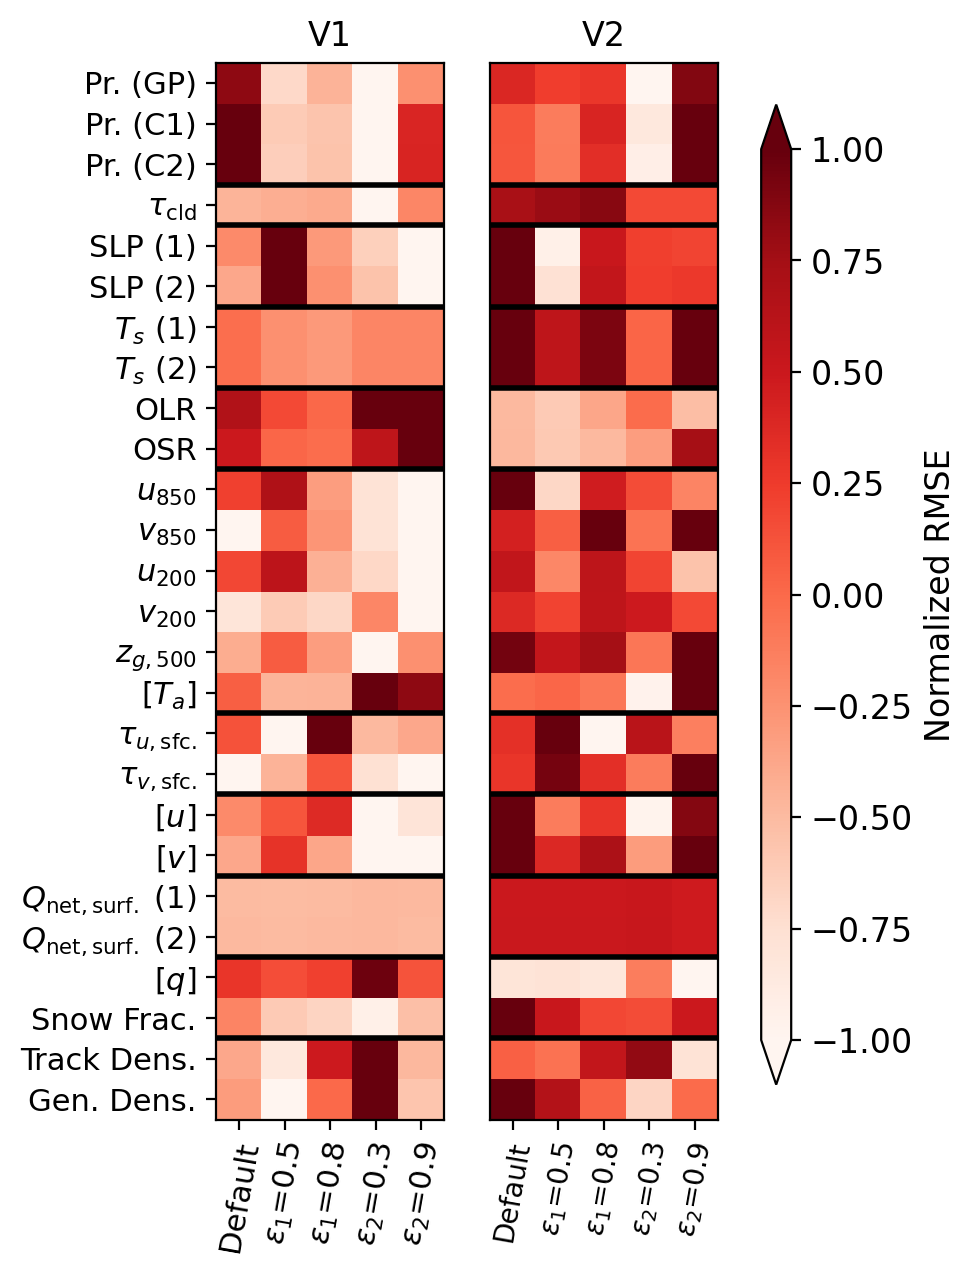

In [28]:
#Same with Reds colormap (weighted version)

fig = plt.figure(figsize=(5,7), dpi=200)

plotmat = np.flipud(norm_RMSE_w)

plt.subplot(1,3,1)
plt.pcolor(plotmat[:,0:5], cmap = plt.cm.Reds, 
           vmin=-1, vmax=1)
plt.title('V1', fontsize=12)
ax = plt.gca()
ax.tick_params(labelsize=11)
ax.set_yticks(np.arange(26)+0.5)
ax.set_yticklabels(np.flip(onames))
ax.set_xticks(np.arange(5)+0.5)
ax.set_xticklabels(['Default', '$\epsilon_1$=0.5', '$\epsilon_1$=0.8', '$\epsilon_2$=0.3', '$\epsilon_2$=0.9'])
plt.xticks(rotation=80)
plt.hlines([2, 4, 6, 8, 10, 16, 18, 20, 22, 23], 
           0, 5, linestyles='solid', linewidth=2, colors='k')

plt.subplot(1,3,2)
plt.pcolor(plotmat[:,5:10], cmap = plt.cm.Reds, 
           vmin=-1, vmax=1)
plt.title('V2', fontsize=12)
ax = plt.gca()
ax.set_yticks([])
ax.set_xticks(np.arange(5)+0.5)
ax.set_xticklabels(['Default', '$\epsilon_1$=0.5', '$\epsilon_1$=0.8', '$\epsilon_2$=0.3', '$\epsilon_2$=0.9'])
plt.xticks(rotation=80)
plt.hlines([2, 4, 6, 8, 10, 16, 18, 20, 22, 23], 
           0, 5, linestyles='solid', linewidth=2, colors='k')

cbar = plt.colorbar(cax=fig.add_axes([0.67, 0.15, 0.03, 0.7]), extend='both')
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_ylabel('Normalized RMSE', fontsize=12)

#
#plt.savefig('plots/V1V2_RMSE_weighted_Reds.png', bbox_inches='tight')
#plt.savefig('plots/V1V2_RMSE_weighted_Reds.pdf', bbox_inches='tight')

#Version with epsilon notation
plt.savefig('plots/V1V2_RMSE_weighted_Reds_epsilon.png', bbox_inches='tight')
plt.savefig('plots/V1V2_RMSE_weighted_Reds_epsilon.pdf', bbox_inches='tight')

#Save npy file
np.save('Figure_S2_data.npy', plotmat)


In [ ]:
#What is unchanged is that we still see actually bigger RMSEs for V2 than V1, even for TC properties.
#This goes along with things like more TCs but in wrong places (so noisy though)

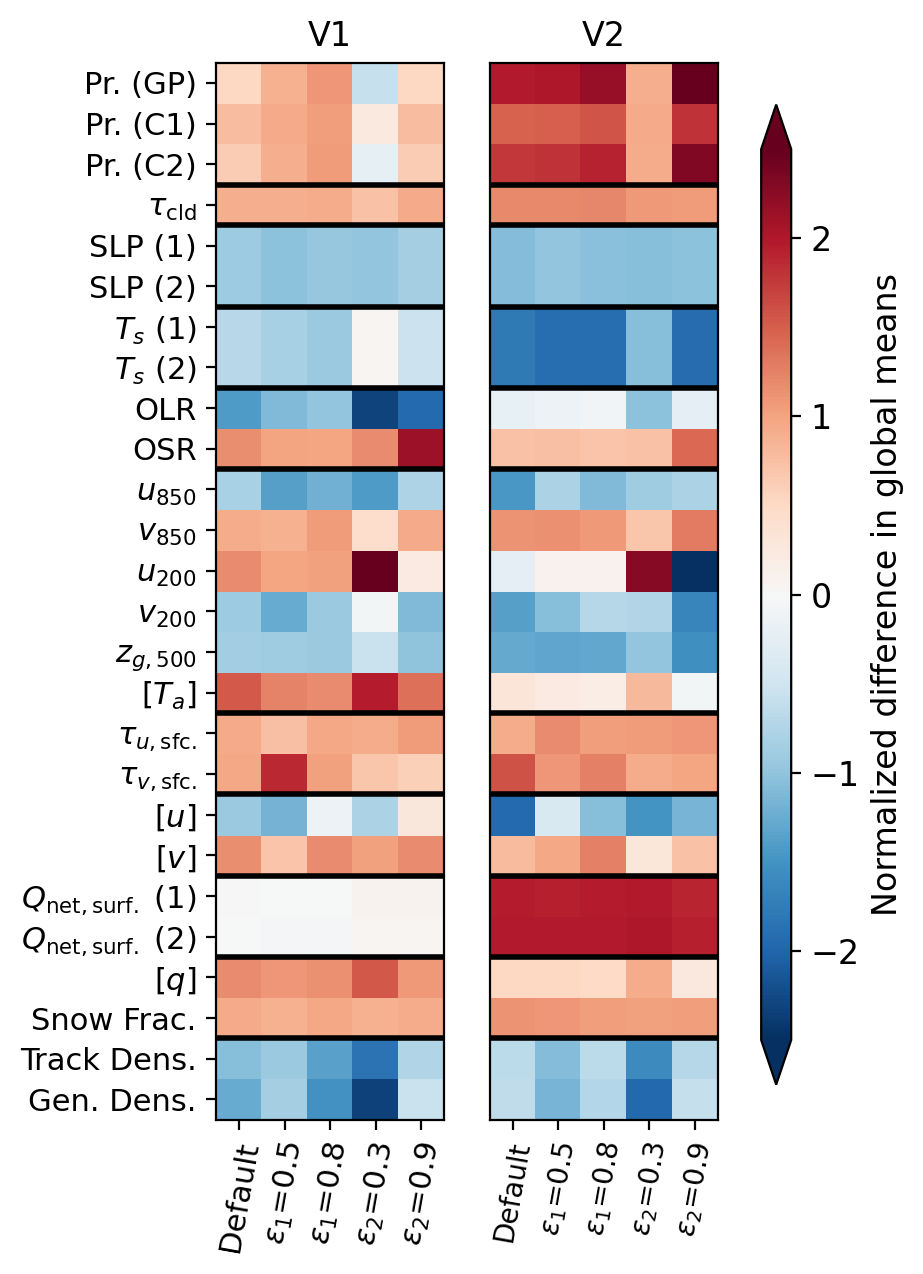

In [29]:
#Ok, what about the difference in global means version?


fig = plt.figure(figsize=(5,7), dpi=200)

plotmat = np.flipud(norm_dgm)

plt.subplot(1,3,1)
plt.pcolor(plotmat[:,0:5], cmap = plt.cm.RdBu_r, 
           vmin=-2.5, vmax=2.5)
plt.title('V1', fontsize=12)
ax = plt.gca()
ax.tick_params(labelsize=11)
ax.set_yticks(np.arange(26)+0.5)
ax.set_yticklabels(np.flip(onames))
ax.set_xticks(np.arange(5)+0.5)
ax.set_xticklabels(['Default', '$\epsilon_1$=0.5', '$\epsilon_1$=0.8', '$\epsilon_2$=0.3', '$\epsilon_2$=0.9'])
plt.xticks(rotation=80)
plt.hlines([2, 4, 6, 8, 10, 16, 18, 20, 22, 23], 
           0, 5, linestyles='solid', linewidth=2, colors='k')

plt.subplot(1,3,2)
plt.pcolor(plotmat[:,5:10], cmap = plt.cm.RdBu_r, 
           vmin=-2.5, vmax=2.5)
plt.title('V2', fontsize=12)
ax = plt.gca()
ax.set_yticks([])
ax.set_xticks(np.arange(5)+0.5)
ax.set_xticklabels(['Default', '$\epsilon_1$=0.5', '$\epsilon_1$=0.8', '$\epsilon_2$=0.3', '$\epsilon_2$=0.9'])
plt.xticks(rotation=80)
plt.hlines([2, 4, 6, 8, 10, 16, 18, 20, 22, 23], 
           0, 5, linestyles='solid', linewidth=2, colors='k')

cbar = plt.colorbar(cax=fig.add_axes([0.67, 0.15, 0.03, 0.7]), extend='both')
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_ylabel('Normalized difference in global means', fontsize=12)


#plt.savefig('plots/V1V2_difference_global_means.png', bbox_inches='tight')
#plt.savefig('plots/V1V2_difference_global_means.pdf', bbox_inches='tight')

plt.savefig('plots/V1V2_difference_global_means_epsilon.png', bbox_inches='tight')
plt.savefig('plots/V1V2_difference_global_means_epsilon.pdf', bbox_inches='tight')

np.save('Figure_14_data.npy', plotmat)